## Imports and Some Settings

In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.optimizers as opti
import tensorflow.keras.activations as acti
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import time
import pandas as pd
import pandas_datareader
from datetime import date
from sklearn.preprocessing import MinMaxScaler

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Some Consts and "Consts"

In [2]:
# Super Hiper Important - Names and "Short Names" of Companies to get their stock prices from web
COMPANIES = {"Apple Inc.": "AAPL",
                  "Tesla Inc.": "TSLA",
                  "Netflix Inc.": "NFLX",
                  "Amazon.com Inc.": "AMZN",
                  "Alphabet Inc.": "GOOG",
                  "Facebook Inc.": "FB"}

# Consts
DATA_SRC = 'yahoo'
START_DATE = '2012-01-01'
DEFAULT_VAL_DAYS = 200
DEFAULT_SCALERS = [MinMaxScaler(feature_range=(0, 1)) for ii in range(len(COMPANIES))]
DEFAULT_LEARN_SIZE = 60
DEFAULT_INPUT_SHAPE = (DEFAULT_LEARN_SIZE, 1)
DEFAULT_SPLIT_PART = 0.8

# Almost Const
END_DATE = date.today().strftime("%Y-%m-%d")
END_DATE = '2019-12-17'

## Loading Datasets

In [3]:
def read_dataset_from_web(dataset_short, data_src=DATA_SRC, start_date=START_DATE, end_date=END_DATE):
    '''
    Loads financial
    '''
    return pandas_datareader.DataReader(dataset_short, data_source=data_src, start=start_date, end=end_date) 

In [4]:
all_raw_datasets = [read_dataset_from_web(COMPANIES[name_short]) for name_short in COMPANIES]
datasets = [buf.filter(['Close']).values for buf in all_raw_datasets]

## Displaying Real Datasets

In [5]:
def display_datasets(sets, datasets, names, title, xlabel, ylabel):
    """
    Displays given datasets
    :param sets: size of figure and position for subplots
    :param datasets: list of datasets
    :param names: names of the companies
    :param title: top title of subplot
    :param xlabel: text for xlabel :o
    :param ylabel: text for ylabel :o
    """
    sub = fig.add_subplot(sets[0], sets[1], sets[2])
    sub.set_title(title, fontsize=24)
    sub.set_xlabel(xlabel, fontsize=20)
    sub.set_ylabel(ylabel, fontsize=20)
    
    for ii in range(len(datasets)):
        y = datasets[ii]
        label = names[ii]
        sub.plot(y, label=label)
    sub.legend(fontsize=16)
    sub.grid()

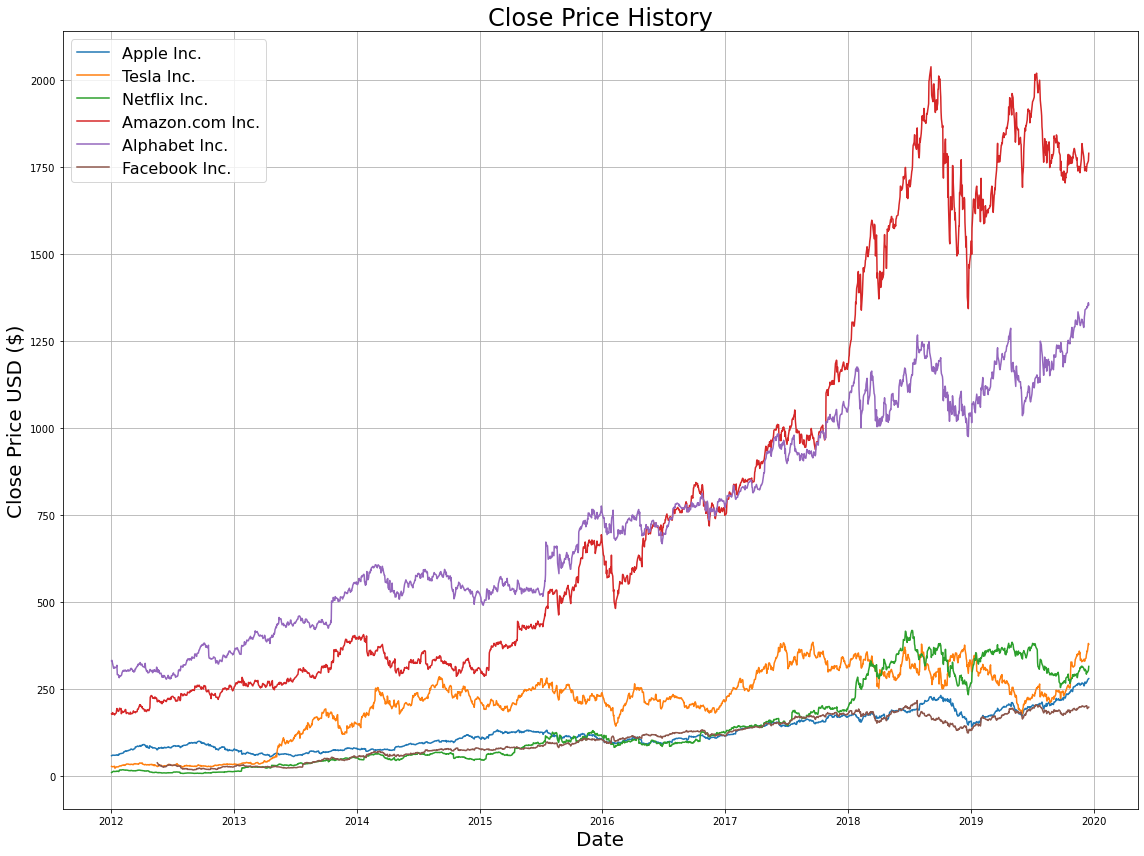

In [6]:
all_raw_datasets_close = [buf['Close'] for buf in all_raw_datasets]
fig = plt.figure(figsize=(16, 12))
display_datasets((1,1,1), all_raw_datasets_close, list(COMPANIES.keys()), 'Close Price History', 'Date', 'Close Price USD ($)')
plt.tight_layout()
plt.draw()

## Data Preprocessing and Splitting into Train/Val Datasets

In [7]:
def split_to_train_set(dataset, part=DEFAULT_SPLIT_PART):
    """
    Generates train dataset from given normalized dataset
    :param sets: size of figure and position for subplots
    :param part: list of datasets
    :return: dictionary with x_train and y_train datasets
    """
    train_size = int(np.ceil(len(dataset) * part))
    buf_train = dataset[:train_size]   
    X = list()
    y = list()
    for ii in range(DEFAULT_LEARN_SIZE,len(buf_train)):
        X.append(dataset[ii-DEFAULT_LEARN_SIZE:ii])
        y.append(dataset[ii,0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0],X.shape[1],1))
    return {"X_train": X, "y_train": y}

def split_to_val_set(dataset, part=DEFAULT_SPLIT_PART):
    train_size = int(np.ceil(len(dataset) * part))
    X = list()
    y = dataset[train_size:, :]
    buf_val = dataset[train_size - DEFAULT_LEARN_SIZE:]
    for ii in range(DEFAULT_LEARN_SIZE,len(buf_val)):
        X.append(buf_val[ii-DEFAULT_LEARN_SIZE:ii, :])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0],X.shape[1],1))
    return {"X_val": X, "y_val": y}

In [8]:
datasets_norm = [DEFAULT_SCALERS[ii].fit_transform(datasets[ii]) for ii in range(len(COMPANIES))]
datasets_train = {list(COMPANIES.keys())[ii]: split_to_train_set(datasets_norm[ii]) for ii in range(len(COMPANIES))}
datasets_val = {list(COMPANIES.keys())[ii]: split_to_val_set(datasets_norm[ii]) for ii in range(len(COMPANIES))}

## Some Models 

In [9]:
def generate_and_compile_model(lstm_units, dense_units, input_shape=DEFAULT_INPUT_SHAPE):
    model = tf.keras.Sequential()
    for ii in range(len(lstm_units)):
        if ii+1 != len(lstm_units):
            buf_layer = layers.LSTM(units=lstm_units[ii], return_sequences=True, input_shape=input_shape)
        else:
            buf_layer = layers.LSTM(units=lstm_units[ii], return_sequences=False)
        model.add(buf_layer)  
    for ii in range(len(dense_units)):
        buf_layer = layers.Dense(units=dense_units[ii])
        model.add(buf_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:
simple_models = {list(COMPANIES.keys())[ii]: generate_and_compile_model([50, 50], [25, 1]) for ii in range(len(COMPANIES))}

## Training / Fitting Models

In [11]:
for train in datasets_train:
    print(train)
    X = datasets_train[train]["X_train"]
    y = datasets_train[train]["y_train"]
    model = simple_models[train]
    model.fit(X, y, batch_size=32, epochs=3, verbose=1)

Apple Inc.
Epoch 1/3
49/49 [==============================] - 3s 53ms/step - loss: 0.0086
Epoch 2/3
49/49 [==============================] - 3s 52ms/step - loss: 3.8393e-04
Epoch 3/3
49/49 [==============================] - 3s 51ms/step - loss: 3.3151e-04
Tesla Inc.
Epoch 1/3
49/49 [==============================] - 3s 54ms/step - loss: 0.0219
Epoch 2/3
49/49 [==============================] - 3s 53ms/step - loss: 0.0012
Epoch 3/3
49/49 [==============================] - 4s 79ms/step - loss: 0.0013
Netflix Inc.
Epoch 1/3
49/49 [==============================] - 4s 72ms/step - loss: 0.0037
Epoch 2/3
49/49 [==============================] - 4s 78ms/step - loss: 3.2512e-04
Epoch 3/3
49/49 [==============================] - 4s 74ms/step - loss: 3.2777e-04
Amazon.com Inc.
Epoch 1/3
49/49 [==============================] - 4s 82ms/step - loss: 0.0090
Epoch 2/3
49/49 [==============================] - 4s 82ms/step - loss: 3.0068e-04
Epoch 3/3
49/49 [==============================] - 4s 79ms/s

## Evaluating Models - Predictions

In [12]:
predictions = list()
for val in datasets_val:
    print(val)
    X = datasets_val[val]["X_val"]
    model = simple_models[val]
    result = model.predict(X, verbose=1)
    predictions.append(result)

predictions = [DEFAULT_SCALERS[ii].inverse_transform(predictions[ii]) for ii in range(len(COMPANIES))]

Apple Inc.
13/13 [==============================] - 0s 17ms/step
Tesla Inc.
13/13 [==============================] - 0s 16ms/step
Netflix Inc.
13/13 [==============================] - 0s 14ms/step
Amazon.com Inc.
13/13 [==============================] - 0s 14ms/step
Alphabet Inc.
13/13 [==============================] - 0s 15ms/step
Facebook Inc.
12/12 [==============================] - 0s 16ms/step


In [19]:
def display_results(original, prediction, i, title, part=DEFAULT_SPLIT_PART, companies=COMPANIES):
    train_size = int(np.ceil(len(datasets[i-1]) * part))
    buf_train = original[:train_size]
    buf_val = original[train_size:]
    buf_val.insert(2, "Predictions", prediction)
    display_datasets((len(companies),1,i), [buf_train['Close'], buf_val['Close'], buf_val['Predictions']], 
                     ['Train', 'Val', 'Predictions'], 'Close Price History: ' + title, 'Date', 'Close Price USD ($)')

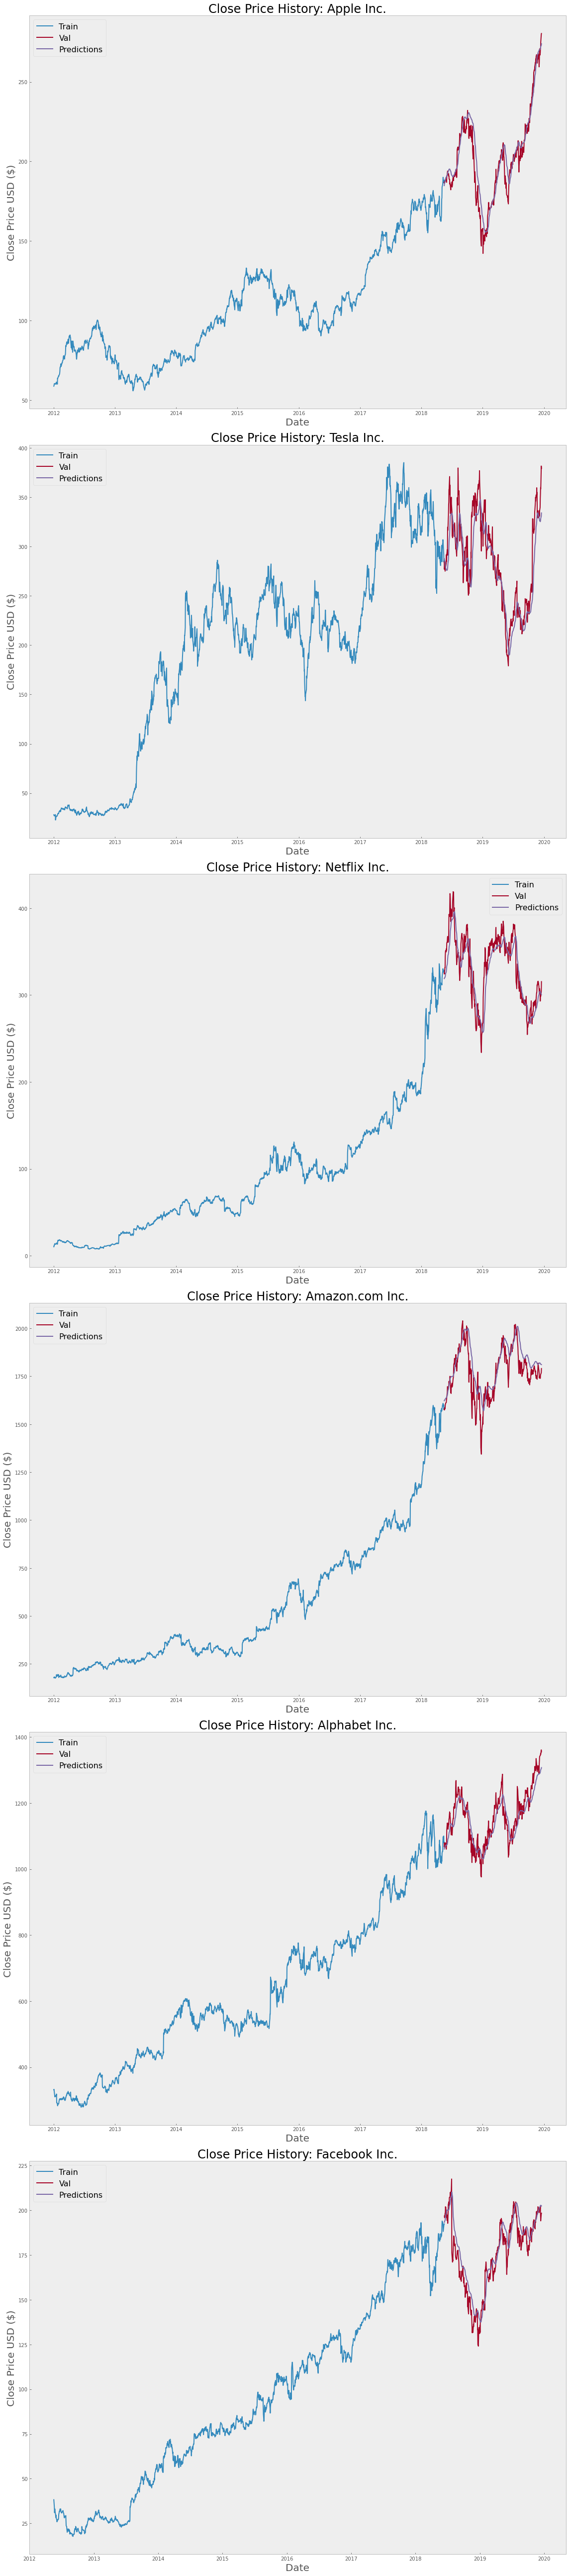

In [25]:
fig = plt.figure(figsize=(16, 72))

for ii in range(len(COMPANIES)):
    display_results(all_raw_datasets[ii], predictions[ii], ii+1, list(COMPANIES.keys())[ii])

plt.tight_layout()
plt.draw()